In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime as dt
from datetime import timedelta
import yfinance as yf

In [23]:
def get_data(stocks, start, end):
    stock_data = yf.download(stocks, start, end)
    stock_data = stock_data['Close']
    returns = stock_data.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix

pf = ['AAPL', 'SHEL', 'JPM', 'COST']
pf_size = len(pf)
mean_returns, cov_matrix = get_data(pf, dt.now() - timedelta(days=300), dt.now())

display(mean_returns)
display(cov_matrix)

[*********************100%***********************]  4 of 4 completed


Ticker
AAPL    0.000976
COST    0.002123
JPM     0.001920
SHEL    0.000115
dtype: float64

Ticker,AAPL,COST,JPM,SHEL
Ticker,,,,
AAPL,0.000208,0.000046,0.000003,0.000019
COST,0.000046,0.000162,0.000024,0.000006
JPM,0.000003,0.000024,0.000143,0.000033
SHEL,0.000019,0.000006,0.000033,0.000102


In [24]:
weights = np.random.random(pf_size)
weights /= np.sum(weights)
display(weights)

array([0.30419323, 0.31746446, 0.25127593, 0.12706638])

In [25]:
mc_sims = 500 # number of simulations
T = 100 # time frame or steps

In [26]:
mean_m = np.full(shape=(T, pf_size), fill_value=mean_returns)
mean_m = mean_m.T
display(mean_m.shape)

(4, 100)

In [27]:
poftfolio_sims = np.full(shape=(T, mc_sims), fill_value=0)
initial_portfolio = 10000

In [28]:
for m in range(mc_sims):
    Z = np.random.normal(size=(T, pf_size))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = mean_m + np.inner(L, Z)
    poftfolio_sims[:,m] = np.cumprod(np.inner(weights, daily_returns.T) + 1) * initial_portfolio
    # display((np.inner(weights, daily_returns.T) + 1))
    # display(np.cumprod(np.inner(weights, daily_returns.T) + 1))

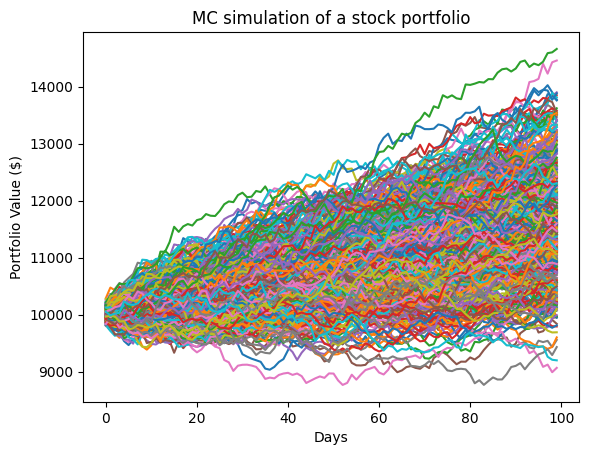

In [29]:
plt.plot(poftfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()


In [30]:
## Pricing option based on the portfolio analysis

# Get the payoff matrix
K = 10500
r = 0.3
payoff = np.maximum(poftfolio_sims[-1,:]- K, 0)
display(payoff)

array([2015,    0, 1018,    0,  100, 3012,  435, 1611,  967, 1447, 1122,
       1900, 1164, 1070,  330,    0,   29,    0,  596, 1444,    0, 1919,
       1740,  799, 1278, 1323, 1867, 2967,  434, 1442, 1242,  432,  891,
        663, 3400, 1108,    0, 1037, 1078, 1831,  387, 2731,    0, 1573,
       2490,  676, 1968, 2412, 2158,  247, 2005,  456, 1594, 1048,  224,
        409, 1099,  766,   37,  912, 2411, 1856, 1184, 3075,  336, 1508,
       2350,    0,  604, 2067,  663,    0, 3014,    0,    0,   66, 1406,
       1195, 2397, 1786, 1743,  532,    0, 1073,  254,  358, 2482, 1117,
       1853,  877, 3274,  585, 2544,   31,  639,  246, 1858, 1652, 1568,
          0,    0, 2214,  284,  789,  677, 1040, 2020, 1085, 1629,    0,
       1531, 1110, 1889, 1584, 2326, 1262,  504, 2576, 2653,  339, 3258,
        782, 2098, 1069,  570, 2043, 1558,  944, 1090, 1076,   70, 1793,
        224, 1154, 1507,   59,  385, 1664, 1593,  482,  904, 1494, 1292,
       1625, 2183,    0, 1029, 1781, 1263, 2063,  7

In [31]:
cashflow_overtime = np.full(shape=(T, mc_sims), fill_value=0.0)
for time in range(T-1, 0, -1):
    if time == T-1:
        cashflow = payoff
    else:
        cashflow = cashflow * np.exp(-r*(T-time)/365)
    cashflow_overtime[time, :] = cashflow

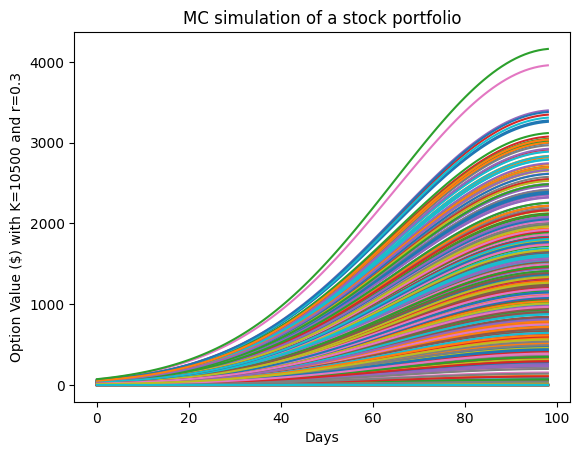

'The value of the option on portfolio with strike-price 10500 for Time-to-expiry 100 days : 20.048764955905025'

In [32]:
plt.plot(cashflow_overtime[1:])
plt.ylabel(f"Option Value ($) with K={K} and r={r}")
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

display(f"The value of the option on portfolio with strike-price {K} for Time-to-expiry {T} days : {np.mean(cashflow_overtime[1])}")

In [33]:
def var(distribution, confidence):
    try:
        return np.percentile(distribution, confidence)
    except:
        raise("Failed to Calculate VaR")

def expected_shortfall(distribution, confidence):
    try:
        value = var(distribution, confidence)
        return np.mean(distribution[distribution <= value]), value
    except:
        raise("Failed to Calulate VaR and ES")

expected_shortfall(poftfolio_sims[-1], 99)

(11607.755555555555, 13810.369999999999)